In [1]:
# Equal-width-discretisation

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import KBinsDiscretizer
from feature_engine.discretisation import EqualWidthDiscretiser

In [11]:
#load the dataset
df = pd.read_csv('titanic.csv',usecols = ['Age','Fare','Survived'])
df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [12]:
#sprit into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Age', 'Fare']],
    data['Survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape


((623, 2), (268, 2))

In [14]:
def impute_na(data, variable):

    df = data.copy()

    # random sampling
    df[variable + '_random'] = df[variable]

    # extract the random sample to fill the na
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)

    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable + '_random'] = random_sample

    return df[variable + '_random']

In [15]:
# replace NA in both train and test sets
X_train['Age'] = impute_na(X_train, 'Age')
X_test['Age'] = impute_na(X_test, 'Age')

X_train['Fare'] = impute_na(X_train, 'Fare')
X_test['Fare'] = impute_na(X_test, 'Fare')


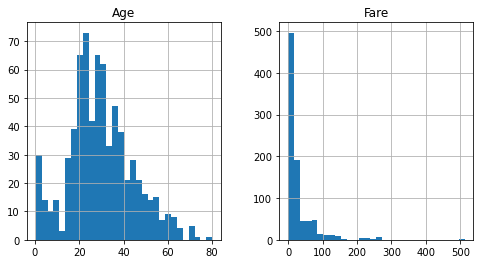

In [16]:
data[['Age','Fare']].hist(bins=30,figsize=(8,4))
plt.show()

#### Equal width discretisation with pandas and NumPy

In [17]:
age_range = X_train['Age'].max() - X_train['Age'].min()
age_range

79.33

In [18]:
# let's divide the range into 8 equal width bins

age_range / 8

9.91625

In [20]:
# now let's capture the lower and upper boundaries

min_value = int(np.floor( X_train['Age'].min()))
max_value = int(np.ceil( X_train['Age'].max()))

# let's round the bin width
inter_value = int(np.round(age_range / 8))

min_value, max_value, inter_value

(0, 80, 10)

In [21]:
# let's capture the interval limits, so we can pass them to the pandas cut 
# function to generate the bins

intervals = [i for i in range(min_value, max_value+inter_value, inter_value)]

intervals


[0, 10, 20, 30, 40, 50, 60, 70, 80]

In [22]:
# let's make labels to label the different bins

labels = ['Bin_' + str(i) for i in range(1, len(intervals))]

labels

['Bin_1', 'Bin_2', 'Bin_3', 'Bin_4', 'Bin_5', 'Bin_6', 'Bin_7', 'Bin_8']

In [24]:
# create binned age / discretise age

# create one column with labels
X_train['Age_disc_labels'] = pd.cut(x=X_train['Age'],
                                    bins=intervals,
                                    labels=labels,
                                    include_lowest=True)

# and one with bin boundaries
X_train['Age_disc'] = pd.cut(x=X_train['Age'],
                             bins=intervals,
                             include_lowest=True)

X_train.head(10)

,Age,Fare,Age_disc_labels,Age_disc
857,51.0,26.5500,Bin_6,"(50.0, 60.0]"
52,49.0,76.7292,Bin_5,"(40.0, 50.0]"
386,1.0,46.9000,Bin_1,"(-0.001, 10.0]"
124,54.0,77.2875,Bin_6,"(50.0, 60.0]"
578,16.0,14.4583,Bin_2,"(10.0, 20.0]"
549,8.0,36.7500,Bin_1,"(-0.001, 10.0]"
118,24.0,247.5208,Bin_3,"(20.0, 30.0]"
12,20.0,8.0500,Bin_2,"(10.0, 20.0]"
157,30.0,8.0500,Bin_3,"(20.0, 30.0]"
127,24.0,7.1417,Bin_3,"(20.0, 30.0]"


/tmp/ipykernel_8893/1252685347.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_train.groupby('Age_disc')['Age'].count().plot.bar()


Text(0, 0.5, 'Number of observations per bin')

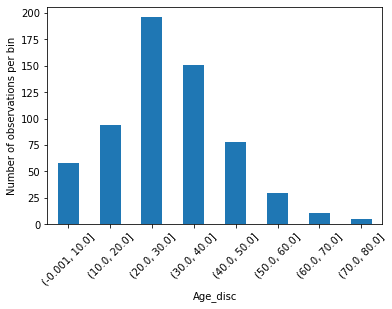

In [25]:
X_train.groupby('Age_disc')['Age'].count().plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')


In [28]:


X_test['Age_disc_labels'] = pd.cut(x=X_test['Age'],
                                   bins=intervals,
                                   labels=labels,
                                   include_lowest=True)

X_test['Age_disc'] = pd.cut(x=X_test['Age'],
                            bins=intervals,
                            include_lowest=True)

X_test.head()



,Age,Fare,Age_disc_labels,Age_disc
495,28.0,14.4583,Bin_3,"(20.0, 30.0]"
648,25.0,7.5500,Bin_3,"(20.0, 30.0]"
278,7.0,29.1250,Bin_1,"(-0.001, 10.0]"
31,2.0,146.5208,Bin_1,"(-0.001, 10.0]"
255,29.0,15.2458,Bin_3,"(20.0, 30.0]"


/tmp/ipykernel_8893/303313373.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t1 = X_train.groupby(['Age_disc'])['Age'].count() / len(X_train)
/tmp/ipykernel_8893/303313373.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t2 = X_test.groupby(['Age_disc'])['Age'].count() / len(X_test)


Text(0, 0.5, 'Number of observations per bin')

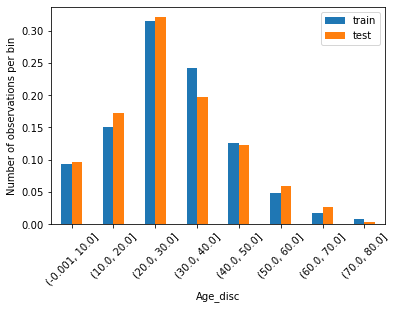

In [29]:
# if the distributions in train and test set are similar, we should expect similar propotion of
# observations in the different intervals in the train and test set
# let's see that below

t1 = X_train.groupby(['Age_disc'])['Age'].count() / len(X_train)
t2 = X_test.groupby(['Age_disc'])['Age'].count() / len(X_test)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

### Equal frequency discretisation

In [30]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import KBinsDiscretizer

from feature_engine.discretisation import EqualFrequencyDiscretiser


In [31]:
#load the dataset
data = pd.read_csv('titanic.csv',usecols = ['Age','Fare','Survived'])
data.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [32]:
#sprit into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Age', 'Fare']],
    data['Survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((623, 2), (268, 2))

In [33]:
def impute_na(data, variable):
    # function to fill NA with a random sample

    df = data.copy()

    # random sampling
    df[variable+'_random'] = df[variable]

    # extract the random sample to fill the na
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)

    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample

    return df[variable+'_random']

In [34]:
X_train['Age'] = impute_na(X_train,'Age')
X_test['Age'] = impute_na(X_test,'Age')

X_train['Fare'] = impute_na(X_train,'Fare')
X_test['Fare'] = impute_na(X_test,'Fare')

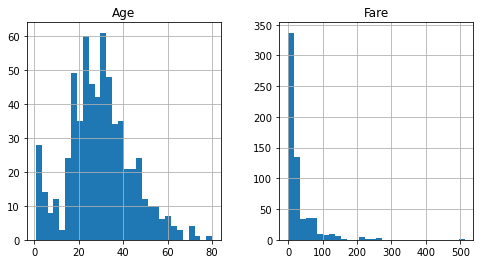

In [35]:
X_train[['Age','Fare']].hist(bins=30,figsize=(8,4))
plt.show()

In [37]:
# let's use pandas qcut (quantile cut) and I indicate that
# we want 10 bins.

# retbins = True indicates that I want to capture the limits
# of each interval (so I can then use them to cut the test set)

Age_disccretised, intervals = pd.qcut(
    X_train['Age'], 10, labels=None, retbins=True, precision=3, duplicates='raise')

pd.concat([Age_disccretised, X_train['Age']], axis=1).head(10)


,Age,Age
857,"(48.0, 80.0]",51.0
52,"(48.0, 80.0]",49.0
386,"(0.669, 12.2]",1.0
124,"(48.0, 80.0]",54.0
578,"(12.2, 19.0]",16.0
549,"(0.669, 12.2]",8.0
118,"(22.0, 26.0]",24.0
12,"(19.0, 22.0]",20.0
157,"(29.0, 32.0]",30.0
127,"(22.0, 26.0]",24.0


In [38]:
intervals

array([ 0.67, 12.2 , 19.  , 22.  , 26.  , 29.  , 32.  , 36.  , 40.  ,
       48.  , 80.  ])

In [39]:
Age_disccretised.value_counts()

Age
(12.2, 19.0]     75
(32.0, 36.0]     74
(22.0, 26.0]     70
(40.0, 48.0]     66
(0.669, 12.2]    63
(29.0, 32.0]     61
(26.0, 29.0]     59
(48.0, 80.0]     58
(19.0, 22.0]     54
(36.0, 40.0]     43
Name: count, dtype: int64

In [40]:
# we can also add labels instead of having the interval boundaries, to the bins, as follows:

labels = ['Q'+str(i) for i in range(1,11)]
labels

['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10']

In [41]:
Age_disccretised, intervals = pd.qcut(X_train['Age'], 10, labels=labels,
                                      retbins=True,
                                      precision=3, duplicates='raise')

Age_disccretised.head()



857    Q10
52     Q10
386     Q1
124    Q10
578     Q2
Name: Age, dtype: category
Categories (10, object): ['Q1' < 'Q2' < 'Q3' < 'Q4' ... 'Q7' < 'Q8' < 'Q9' < 'Q10']

In [42]:
# to apply the intervals to the test set, we need to extend
# the limits of the outer bins to -inf and +inf, so that if
# in the test set, there are smaller or bigger values than the 
# minimum or maximum values in the train set, they can be 
# accomodated in the outer intervals. 
# Otherwise, they will be replaced by NaN.

# Prepend/Append infinities to accommodate outliers
intervals[0] = float("-inf")
intervals[len(intervals) - 1] = float("inf")

intervals


array([-inf, 12.2, 19. , 22. , 26. , 29. , 32. , 36. , 40. , 48. ,  inf])

In [43]:
# to transform the test set:
# we use pandas cut method (instead of qcut) and
# pass the quantile edges calculated in the training set

X_test['Age_disc_label'] = pd.cut(x = X_test['Age'], bins=intervals, labels=labels)
X_test['Age_disc'] = pd.cut(x = X_test['Age'], bins=intervals)

X_test.head(10)


,Age,Fare,Age_disc_label,Age_disc
495,28.0,14.4583,Q5,"(26.0, 29.0]"
648,25.0,7.5500,Q4,"(22.0, 26.0]"
278,7.0,29.1250,Q1,"(-inf, 12.2]"
31,2.0,146.5208,Q1,"(-inf, 12.2]"
255,29.0,15.2458,Q5,"(26.0, 29.0]"
298,44.0,30.5000,Q9,"(40.0, 48.0]"
609,40.0,153.4625,Q8,"(36.0, 40.0]"
318,31.0,164.8667,Q6,"(29.0, 32.0]"
484,25.0,91.0792,Q4,"(22.0, 26.0]"
367,40.5,7.2292,Q9,"(40.0, 48.0]"


In [45]:
X_test['Age_disc_label'].isnull().sum()

0

/tmp/ipykernel_8893/2983841176.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_test.groupby('Age_disc')['Age'].count().plot.bar()


<AxesSubplot:xlabel='Age_disc'>

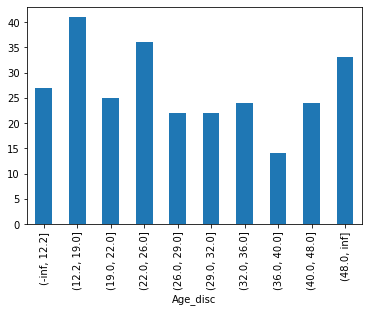

In [46]:
X_test.groupby('Age_disc')['Age'].count().plot.bar()

### Equal frequency discretisation with Feature-Engine

In [47]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Age', 'Fare']],
    data['Survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape


# replace NA in both  train and test sets

X_train['Age'] = impute_na(data, 'Age')
X_test['Age'] = impute_na(data, 'Age')

X_train['Fare'] = impute_na(data, 'Fare')
X_test['Fare'] = impute_na(data, 'Fare')



In [48]:
# with feature engine we can automate the process for many variables
# in one line of code

disc = EqualFrequencyDiscretiser(q=10, variables = ['Age', 'Fare'])

disc.fit(X_train)


EqualFrequencyDiscretiser(variables=['Age', 'Fare'])

In [49]:
# in the binner dict, we can see the limits of the intervals. Note
# that the intervals have different widths

disc.binner_dict_


{'Age': [-inf,
  13.200000000000003,
  19.0,
  22.0,
  26.0,
  29.0,
  32.0,
  36.0,
  41.60000000000002,
  49.0,
  inf],
 'Fare': [-inf,
  7.72584,
  7.88252,
  8.05,
  12.130000000000008,
  15.0,
  23.45,
  27.75,
  46.9,
  77.17584000000004,
  inf]}

In [50]:
# transform train and text

train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

train_t.head()



,Age,Fare
857,9,6
52,8,8
386,0,7
124,9,9
578,1,4


Text(0, 0.5, 'Number of observations per bin')

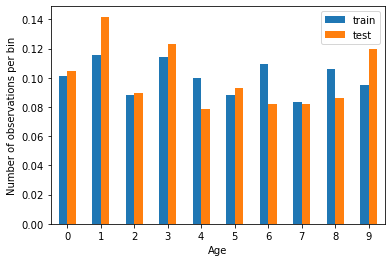

In [51]:
# and now let's explore the number of observations per bucket

t1 = train_t.groupby(['Age'])['Age'].count() / len(train_t)
t2 = test_t.groupby(['Age'])['Age'].count() / len(test_t)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

### Domain-knowledge-discretisation

In [53]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# load the Titanic Dataset

data = pd.read_csv('titanic.csv',
                   usecols=['Age', 'Survived'])

data.head()



,Survived,Age
0,0,22.0
1,1,38.0
2,1,26.0
3,1,35.0
4,0,35.0


In [54]:
def impute_na(data, variable):
    df = data.copy()

    # random sampling
    df[variable+'_random'] = df[variable]

    # extract the random sample to fill the na
    random_sample = data[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)

    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample

    return df[variable+'_random']

In [55]:
#let's fill the missing data
data['Age'] = impute_na(data,'Age')

In [62]:

# bucket boundaries
buckets = [0, 20, 40, 60, 1000]

# bucket labels
labels = ['0-20', '20-40', '40-60', '>60']
# discretisation
data['Age_buckets_labels'] = pd.cut(
    data['Age'], bins=buckets, labels=labels, include_lowest=True)

data['Age_buckets'] = pd.cut(data['Age'], bins=buckets, include_lowest=True)

data.head()


,Survived,Age,Age_buckets_labels,Age_buckets
0,0,22.0,20-40,"(20.0, 40.0]"
1,1,38.0,20-40,"(20.0, 40.0]"
2,1,26.0,20-40,"(20.0, 40.0]"
3,1,35.0,20-40,"(20.0, 40.0]"
4,0,35.0,20-40,"(20.0, 40.0]"


In [63]:
data.tail()

,Survived,Age,Age_buckets_labels,Age_buckets
886,0,27.0,20-40,"(20.0, 40.0]"
887,1,19.0,0-20,"(-0.001, 20.0]"
888,0,15.0,0-20,"(-0.001, 20.0]"
889,1,26.0,20-40,"(20.0, 40.0]"
890,0,32.0,20-40,"(20.0, 40.0]"


/tmp/ipykernel_8893/1208682872.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby('Age_buckets_labels')['Age'].count().plot.bar()


<AxesSubplot:xlabel='Age_buckets_labels'>

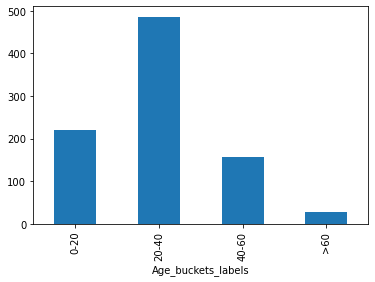

In [64]:
data.groupby('Age_buckets_labels')['Age'].count().plot.bar()

/tmp/ipykernel_8893/3718144407.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby('Age_buckets_labels')['Survived'].mean().plot.bar()


<AxesSubplot:xlabel='Age_buckets_labels'>

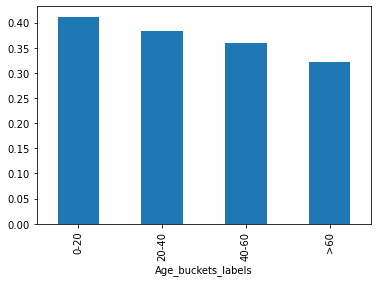

In [65]:
# survival rate per age bucket

data.groupby('Age_buckets_labels')['Survived'].mean().plot.bar()
